In [33]:
import os

import numpy as np

import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib notebook

import imars3d
import tomopy
import timeit

from imars3d.ui.widgets import Tqdm
import panel as pn

from imars3d.backend.dataio.data import load_data, _get_filelist_by_dir
from imars3d.backend.morph.crop import crop, detect_bounds
from imars3d.backend.corrections.gamma_filter import gamma_filter
from imars3d.backend.preparation.normalization import normalization
from imars3d.backend.diagnostics import tilt
from imars3d.backend.diagnostics.rotation import find_rotation_center
from imars3d.backend.corrections.ring_removal import remove_ring_artifact
from imars3d.backend.reconstruction import recon
from imars3d.backend.dataio.data import save_data

import bm3d

In [2]:
!conda info --envs

# conda environments:
#
_build                   /SNS/users/j35/.conda/envs/_build
jupyter_imaging          /SNS/users/j35/.conda/envs/jupyter_imaging
jupyter_imaging_py36     /SNS/users/j35/.conda/envs/jupyter_imaging_py36
py36                     /SNS/users/j35/.conda/envs/py36
base                     /SNS/users/j35/miniconda3
angel                    /SNS/users/j35/miniconda3/envs/angel
imars3d                  /SNS/users/j35/miniconda3/envs/imars3d
imars3d-test             /SNS/users/j35/miniconda3/envs/imars3d-test
imars3d_py27             /SNS/users/j35/miniconda3/envs/imars3d_py27
maha                     /SNS/users/j35/miniconda3/envs/maha
mylocal_python36         /SNS/users/j35/miniconda3/envs/mylocal_python36
mylocal_python37         /SNS/users/j35/miniconda3/envs/mylocal_python37
remove_me                /SNS/users/j35/miniconda3/envs/remove_me
rockit                   /SNS/users/j35/miniconda3/envs/rockit



In [3]:
imars3d.__version__

'1.1.0.dev235'

In [4]:
ncore = 10

In [5]:
ct_dir = "/HFIR/CG1D/IPTS-31148/raw/ct_scans/December3_2022"
assert os.path.exists(ct_dir)

ob_dir = "/HFIR/CG1D/IPTS-31148/raw/ob/December3_2022"
assert os.path.exists(ob_dir)

dc_dir = "/HFIR/CG1D/IPTS-31148/raw/dc/2022_12_05"
assert os.path.exists(dc_dir)

# Load data 

In [6]:
t0 = timeit.default_timer()

pn.extension()
tqdm = Tqdm()
display(tqdm)

proj_raw, ob_raw, dc_raw, rot_angles = load_data(ct_dir=ct_dir,
                                   ob_dir=ob_dir,
                                   dc_dir=dc_dir,
                                   ct_fnmatch="*.tiff",
                                   ob_fnmatch="*.tiff",
                                   dc_fnmatch="*.tiff", tqdm_class=tqdm)
proj_min = np.min(proj_raw, axis=0)
t1 = timeit.default_timer()
print(f"time: {t1-t0} s")

Tqdm(layout=Column, progress=Progress, text_pane=Str)

/opt/anaconda/envs/imars3d-dev/lib/python3.10/site-packages/imars3d/backend/dataio/data.py:241: TqdmWarning: Iterable length 1288 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  rst = process_map(partial(_forgiving_reader, reader=reader), filelist, **kwargs)


time: 62.35727393999696 s


<IPython.core.display.Javascript object>


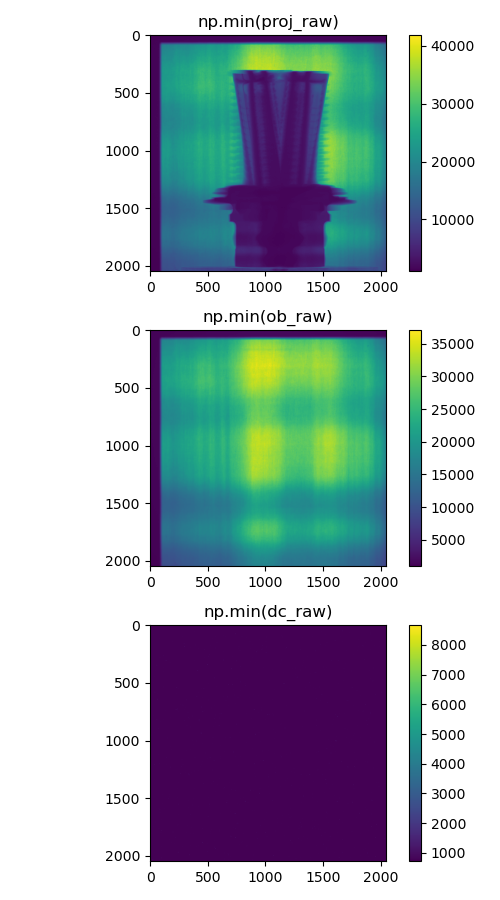

In [7]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,9))
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)

plt0 = ax0.imshow(proj_min)
fig.colorbar(plt0, ax=ax0)
ax0.set_title("np.min(proj_raw)")

plt1 = ax1.imshow(ob_min)
fig.colorbar(plt1, ax=ax1)
ax1.set_title("np.min(ob_raw)")

plt2 = ax2.imshow(dc_max)
fig.colorbar(plt2, ax=ax2)
ax2.set_title("np.min(dc_raw)")

fig.tight_layout()

# Crop 

In [8]:
crop_region = [319, 1855, 162, 1994]    # [left, right, top, bottom]

In [9]:
proj_crop = crop(arrays=proj_raw,
         crop_limit=crop_region)
ob_crop = crop(arrays=ob_raw,
         crop_limit=crop_region)
dc_crop = crop(arrays=dc_raw,
         crop_limit=crop_region)
proj_crop_min = crop(arrays=proj_min,
                    crop_limit=crop_region)

<IPython.core.display.Javascript object>


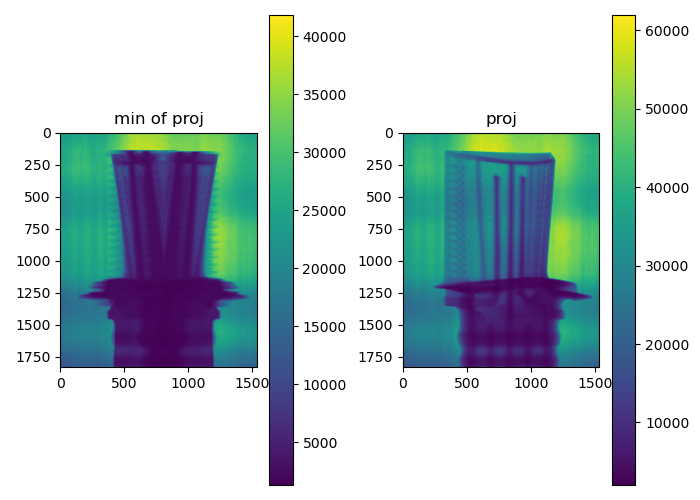

In [10]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(7,5))

fig1 = ax0.imshow(proj_crop_min)
plt.colorbar(fig1, ax=ax0)
ax0.set_title("min of proj")

fig2 = ax1.imshow(proj_crop[0])
plt.colorbar(fig2, ax=ax1)
ax1.set_title("proj")

plt.tight_layout()

# gamma filtering 

In [11]:
t0 = timeit.default_timer()
proj_gamma = gamma_filter(arrays=proj_crop, 
                        selective_median_filter=False, 
                        diff_tomopy=20, 
                        max_workers=48, 
                        median_kernel=3)
ob_gamma = ob_crop
dc_gamma = dc_crop
t1 = timeit.default_timer()
print(f"time: {t1-t0} s")

Switch to use standard uint16 threshold as given arrays are float type.


time: 60.46144277602434 s


<IPython.core.display.Javascript object>


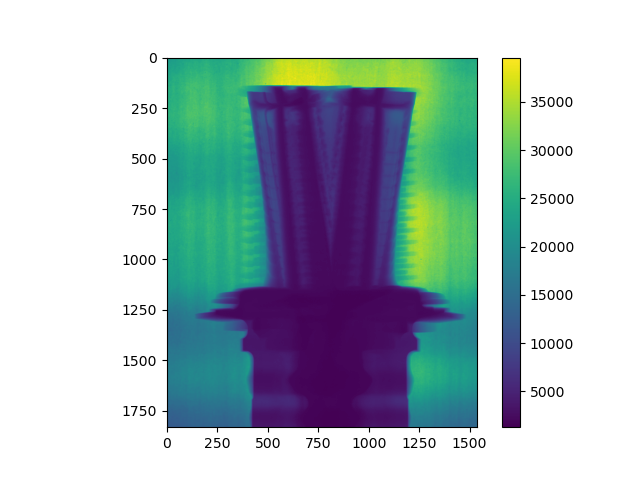

In [12]:
proj_gamma_min = np.min(proj_gamma, axis=0)
plt.figure(num="Gamma filtering")
plt.imshow(proj_gamma_min)
plt.colorbar()

# normalization 

In [13]:
t0 = timeit.default_timer()
proj_norm = normalization(arrays=proj_gamma,
                          flats=ob_gamma,
                          darks=dc_gamma)
t1 = timeit.default_timer()
print(f"time: {t1-t0} s")

time: 49.165490325540304 s


<IPython.core.display.Javascript object>


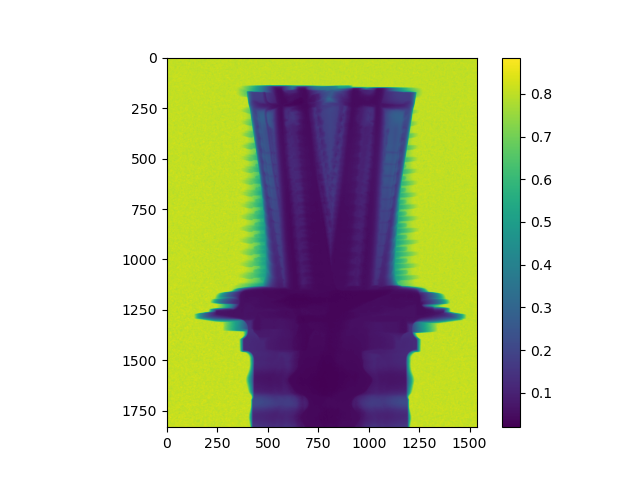

In [14]:
plt.figure()
proj_norm_min = np.min(proj_norm, axis=0)
plt.imshow(proj_norm_min)
plt.colorbar()

In [21]:
# my_ob = np.median(ob_gamma, axis=0)
# my_dc = np.median(dc_gamma, axis=0)

# proj_norm = []
# for ct in proj_gamma:
#     proj_norm.append(np.true_divide(ct-my_dc, my_ob-my_dc))

# proj_norm = np.asarray(proj_norm)

In [22]:
# fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# proj_norm_min = np.min(proj_norm, axis=0)
# fig1 = ax0.imshow(proj_norm_min)
# plt.colorbar(fig1, ax=ax0)

# proj_norm1_min = np.min(proj_norm1, axis=0)
# fig2 = ax1.imshow(proj_norm1_min)
# plt.colorbar(fig2, ax=ax1)

# beam fluctuation 

Using normalize_roi because part of the rotation stage is in the way and does not allow to use normalize_bg

In [15]:
bg_region = [0, 250, 0, 1100]  #  [left, right, top, bottom]

<IPython.core.display.Javascript object>


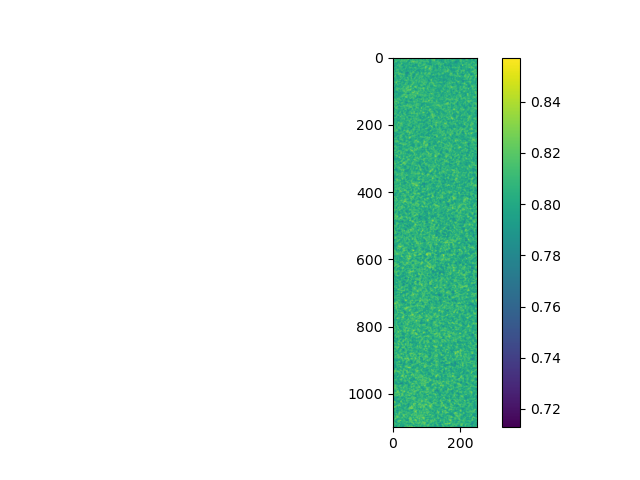

In [16]:
proj_norm_bg = proj_norm[:, bg_region[2]: bg_region[3],
                            bg_region[0]: bg_region[1]]
proj_norm_bg_min = np.min(proj_norm_bg, axis=0)
plt.figure()
plt.imshow(proj_norm_bg_min)
plt.colorbar()

In [17]:
roi = [bg_region[2], bg_region[0],
       bg_region[3], bg_region[1]]

In [18]:
t0 = timeit.default_timer()
proj_norm_beam_fluctuation = tomopy.prep.normalize.normalize_roi(proj_norm,
                                               roi=roi,
                                               ncore=ncore)
t1 = timeit.default_timer()
print(f"time: {t1-t0} s")

time: 32.34922257810831 s


<IPython.core.display.Javascript object>


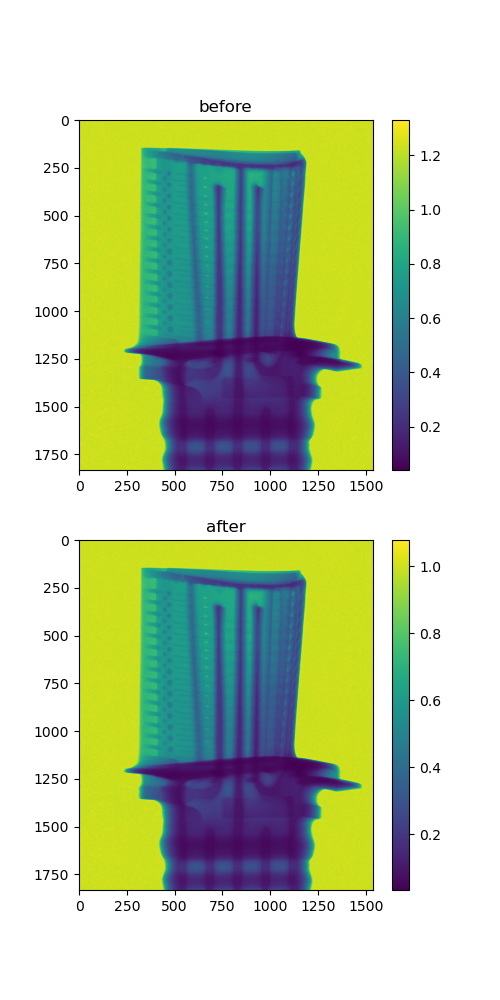

In [19]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1,
                               num="Beam fluctuation",
                               figsize=(5,10))

# before beam fluctuation
#proj_norm_min = np.min(proj_norm, axis=0)
#fig0 = ax0.imshow(proj_norm_min)
fig0 = ax0.imshow(proj_norm[0])
ax0.set_title("before")
plt.colorbar(fig0, ax=ax0)

# after beam fluctuation
# proj_norm_beam_fluctuation_min = np.min(proj_norm_beam_fluctuation, axis=0)
# fig1 = ax1.imshow(proj_norm_beam_fluctuation_min)
fig1 = ax1.imshow(proj_norm_beam_fluctuation[0])
ax1.set_title("after")
plt.colorbar(fig1, ax=ax1)


# attenuation to transmission

In [20]:
proj_mlog = tomopy.minus_log(proj_norm_beam_fluctuation)

<IPython.core.display.Javascript object>


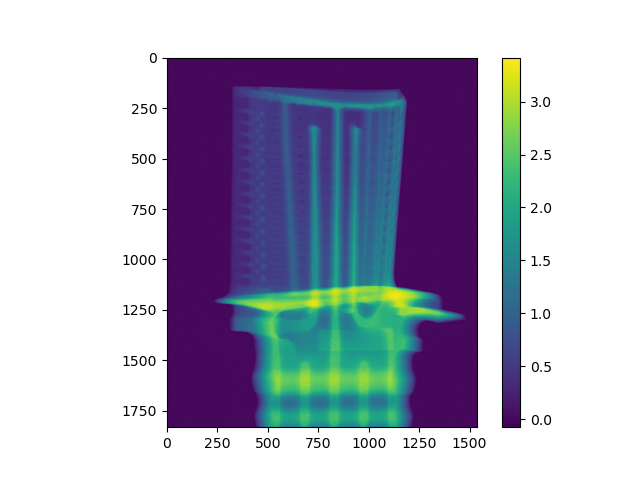

In [21]:
# proj_mlog_min = np.min(proj_mlog, axis=0)
plt.figure()
plt.imshow(proj_mlog[0])
plt.colorbar()

# Tilt correction (zzz)

Manually calculating the `atol` parameter

In [22]:
delta_angle = rot_angles[1] - rot_angles[0]
mean_delta_angle = np.mean([y-x for (x,y) in zip(rot_angles[:-1], rot_angles[1:])])

list_180_deg_pairs_idx = tilt.find_180_deg_pairs_idx(angles=rot_angles,
                                                    atol=mean_delta_angle)

checking that the 180degrees file found is correct

In [23]:
from imars3d.backend.dataio.data import _get_filelist_by_dir

In [24]:
index_0_degree = list_180_deg_pairs_idx[0][0]
index_180_degree = list_180_deg_pairs_idx[1][0]


list_ct_files, list_ob_files, list_dc_files = _get_filelist_by_dir(ct_dir=ct_dir,
                                                                  ob_dir=ob_dir)

file_0_degree = list_ct_files[index_0_degree]
file_180_degree = list_ct_files[index_180_degree]
file_180_next_degree = list_ct_files[index_180_degree+1]

print(f"{index_0_degree =}")
print(f"{index_180_degree =}")

print(f"file 0 degrees: {os.path.basename(file_0_degree)}")
print(f"file 180 degrees: {os.path.basename(file_180_degree)}")
print(f"next file is: {os.path.basename(file_180_next_degree)}")

dc_dir is None.


index_0_degree =0
index_180_degree =642
file 0 degrees: 20221203_SmallTurbine_0050_000_000_0000.tiff
file 180 degrees: 20221204_SmallTurbine_0050_179_760_0642.tiff
next file is: 20221204_SmallTurbine_0050_180_040_0643.tiff


Calculate tilt correction value

In [25]:
t0 = timeit.default_timer()
tilt_angle = tilt.calculate_tilt(image0=proj_mlog[index_0_degree],
                                image180=proj_mlog[index_180_degree])
print(f"tilt_angle: {tilt_angle}")
t1 = timeit.default_timer()
print(f"time: {t1-t0} s")

tilt_angle:      fun: 0.0011279747
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 34
     nit: 30
 success: True
       x: 0.02878749563754079
time: 28.815524999052286 s


apply the tilt correction

In [26]:
t0 = timeit.default_timer()

pn.extension()
tqdm = Tqdm()
display(tqdm)

proj_tilt_corrected = tilt.apply_tilt_correction(arrays=proj_mlog,
                                                tilt=tilt_angle.x,
                                                tqdm_class=tqdm)
t1 = timeit.default_timer()
print(f"time: {t1-t0} s")

Tqdm(layout=Column, progress=Progress, text_pane=Str)

/opt/anaconda/envs/imars3d-dev/lib/python3.10/site-packages/imars3d/backend/diagnostics/tilt.py:414: TqdmWarning: Iterable length 1288 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  rst = process_map(


time: 140.39859943836927 s


### checking if tilt applied worked

<IPython.core.display.Javascript object>


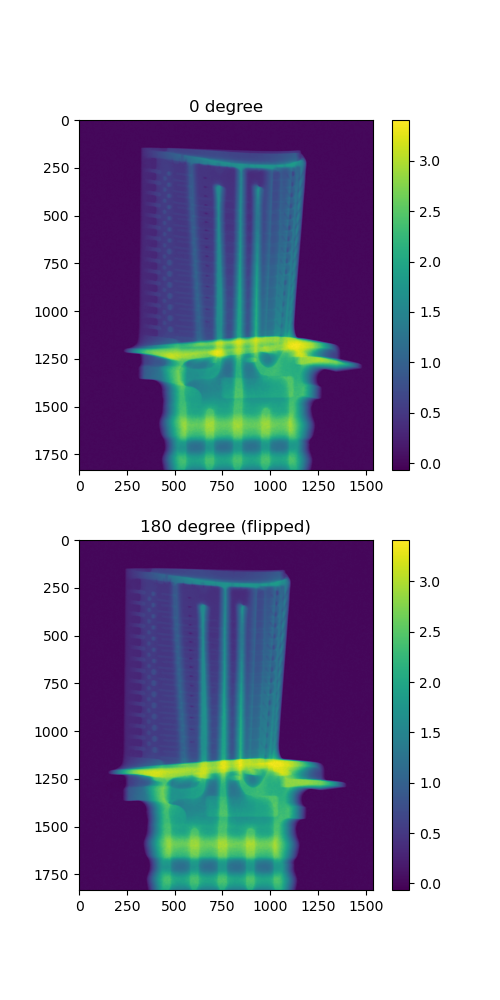

In [27]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1,
                               num="Tilt correction",
                               figsize=(5,10))

# before beam fluctuation
#proj_norm_min = np.min(proj_norm, axis=0)
#fig0 = ax0.imshow(proj_norm_min)
fig0 = ax0.imshow(proj_tilt_corrected[index_0_degree])
ax0.set_title("0 degree")
plt.colorbar(fig0, ax=ax0)

# after beam fluctuation
# proj_norm_beam_fluctuation_min = np.min(proj_norm_beam_fluctuation, axis=0)
# fig1 = ax1.imshow(proj_norm_beam_fluctuation_min)
fig1 = ax1.imshow(np.fliplr(proj_tilt_corrected[index_180_degree]))
ax1.set_title("180 degree (flipped)")
plt.colorbar(fig1, ax=ax1)

# Rotation center (zzz)

In [28]:
t0 = timeit.default_timer()

pn.extension()
tqdm = Tqdm()
display(tqdm)

rot_center = find_rotation_center(arrays=proj_tilt_corrected,
                                 angles=rot_angles,
                                 in_degrees=True,
                                 atol_deg=mean_delta_angle,
                                 tqdm_class=tqdm
                                 )
t1 = timeit.default_timer()
print(f"time: {t1-t0} s")

Tqdm(layout=Column, progress=Progress, text_pane=Str)

/opt/anaconda/envs/imars3d-dev/lib/python3.10/site-packages/imars3d/backend/diagnostics/rotation.py:111: TqdmWarning: Iterable length 1291 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  rst = process_map(


time: 361.3859962299466 s


In [29]:
print(f"{rot_center=}")

rot_center=(808.75,)


# Strikes removal

### using imars3d - ketcham method working on 3D stack

In [30]:
t0 = timeit.default_timer()

pn.extension()
tqdm = Tqdm()
display(tqdm)

proj_strikes_removed = remove_ring_artifact(arrays=proj_tilt_corrected,
                                           kernel_size=5,
                                           max_workers=ncore,
                                           tqdm_class=tqdm)


t1 = timeit.default_timer()
print(f"time= {t1-t0} s")

Tqdm(layout=Column, progress=Progress, text_pane=Str)

/opt/anaconda/envs/imars3d-dev/lib/python3.10/site-packages/imars3d/backend/corrections/ring_removal.py:106: TqdmWarning: Iterable length 1832 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  rst = process_map(


time= 132.22582091391087 s


In [40]:
# fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1,
#                                num="imars3d ketcham ",
#                                figsize=(5,10))

# # before beam fluctuation
# #proj_norm_min = np.min(proj_norm, axis=0)
# #fig0 = ax0.imshow(proj_norm_min)
# fig0 = ax0.imshow(proj_tilt_corrected[0])
# ax0.set_title("before")
# plt.colorbar(fig0, ax=ax0)

# # after beam fluctuation
# # proj_norm_beam_fluctuation_min = np.min(proj_norm_beam_fluctuation, axis=0)
# # fig1 = ax1.imshow(proj_norm_beam_fluctuation_min)
# fig1 = ax1.imshow(proj_strikes_removed[0])
# ax1.set_title("after")
# plt.colorbar(fig1, ax=ax1)

### using tomopy (Vo)

In [41]:
# nchunk = int(proj_tilt_corrected.shape[0]/ncore) + 1
# print(f"chunk size: {nchunk}")

# t0 = timeit.default_timer()
# proj_strikes_removed = tomopy.remove_all_stripe(proj_tilt_corrected,
#                                                ncore=ncore,
#                                                nchunk=nchunk)

# t1 = timeit.default_timer()
# print(f"time= {t1-t0:.2f} s")

In [42]:
# fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1,
#                                num="tomopy Vo ",
#                                figsize=(5,10))

# # before beam fluctuation
# #proj_norm_min = np.min(proj_norm, axis=0)
# #fig0 = ax0.imshow(proj_norm_min)
# fig0 = ax0.imshow(proj_tilt_corrected[0])
# ax0.set_title("before")
# plt.colorbar(fig0, ax=ax0)

# # after beam fluctuation
# # proj_norm_beam_fluctuation_min = np.min(proj_norm_beam_fluctuation, axis=0)
# # fig1 = ax1.imshow(proj_norm_beam_fluctuation_min)
# fig1 = ax1.imshow(proj_strikes_removed[0])
# ax1.set_title("after")
# plt.colorbar(fig1, ax=ax1)

### bm3d

In [43]:
# import bm3d_streak_removal as bm3d

In [44]:
# t0 = timeit.default_timer()
# proj_mlog = 




# t1 = timeit.default_timer()
# print(f"time: {t1-t0: .2f} s")

# Reconstruction 

In [39]:
t0 = timeit.default_timer()

# converting angles from deg to radians
rot_ang_rad = np.radians(rot_angles)

reconstruction = recon(arrays=proj_strikes_removed,
             center=rot_center[0],
             theta=rot_ang_rad,
             )

t1 = timeit.default_timer()
print(f"time: {t1-t0:.2f} s")

time: 28.31 s


<IPython.core.display.Javascript object>


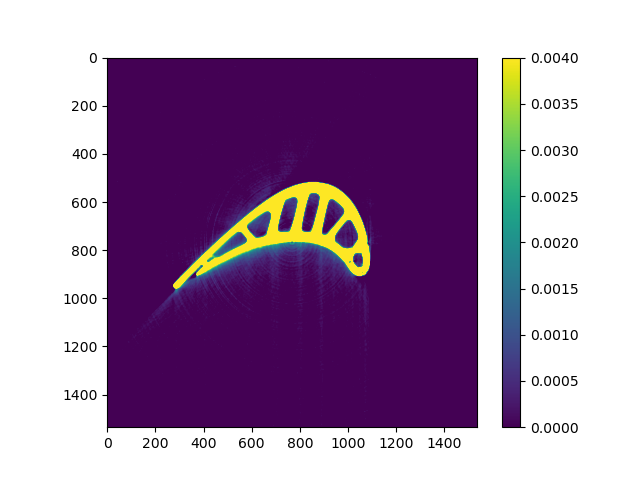

In [41]:
plt.figure()
plt.imshow(reconstruction[1000], vmin=0, vmax=0.004)
plt.colorbar()


# Export


In [43]:
output_folder = "/HFIR/CG1D/IPTS-31148/shared/processed_data"
save_data(data=np.asarray(reconstruction),
         outputbase=output_folder,
         name="small_turbine")


PosixPath('/HFIR/CG1D/IPTS-31148/shared/processed_data/small_turbine_202212051316')